<a href="https://colab.research.google.com/github/IsaacFigNewton/DAG-Based-Compression/blob/main/DAG_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO



1.   Map suffix tree tokens to token composition DAG
    *   Represent tokens at each level of the suffix tree as a sequential combination of smaller tokens
    *   Map all tokens to nodes
    *   Convert references to previous tokens to edges that map to locations in current node
    *   Convert this DAG to an edge list
    *   Plot the DAG with NX
2.  Represent each token embedding with a sparse matrix of dimensions n x m where n=number of unique characters and m=number of unique character positions
3.  Represent vectorization of text as third dimension, with token vector scaling corresponding to token frequencies

# Install packages and import libraries

In [1]:
from queue import Queue
import numpy as np
import urllib.request as url
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')

#Important functions

##Utility

In [2]:
def tokenize(text, token_dict, max_token_len):
    # filter to include only tokens shorter than the
    available_tokens = {token: freq for token, freq in token_dict.items() if len(token) <= max_token_len}

    # sort tokens by length and secondarily frequency
    best_tokens = sorted(list(available_tokens.items()),
                         key=lambda x: (-len(x[0]), -x[1]))

    # extract tokens from the ordered list
    tokenization = []
    while text != "":
        for token, freq in best_tokens:
            if text.startswith(token):
                tokenization.append(token)
                text = text[len(token):]

    return tokenization

In [3]:
def print_tree(tree, indent = 0):
    # Iterate over the child.suffixes (features) in the tree
    for child in tree.children:
        print(' ' * indent + str(child.suffix) + ": " + str(child.frequency))
        # If the child is a SuffixNode, recursively print the subtree
        if isinstance(child, SuffixNode):
            print_tree(child, indent + 4)
        else:
            print(' ' * (indent + 4) + "\"" + str(child.suffix) + "\": " + str(child.frequency))

## Classes

### SuffixNode Class

In [4]:
class SuffixNode:
    def __init__(self,
                 suffix=None,
                 token=None,
                 frequency=0,
                 parent=None,
                 children=None):
        self.suffix = suffix
        self.token = token
        self.frequency = frequency

        self.parent = parent

        if children is None:
            children = set()  # Initialize children as an empty set
        self.children = children

    def __str__(self):
        return self.suffix


    def split_edge(self, child, i):
      old_suffix = child.suffix[i:]
      new_suffix = self.suffix[i:]

      # Replace the old entry for the current node with a new one for the edge split
      split_node = SuffixNode(suffix=child.suffix[:i],
                              frequency=child.frequency,
                              parent=self,
                              children=child.children)

      # Remove the old child and add the new split node
      self.children.remove(child)
      self.children.add(split_node)

      # Create a new node for the existing edge suffix
      new_child = SuffixNode(suffix=old_suffix,
                              frequency=1,
                              parent=split_node,
                              children=split_node.children)

      # Transfer the children to the new split node's child
      for grandchild in split_node.children:
          grandchild.parent = new_child

      # Create a new node for the new suffix
      #     and move both it and the previous suffix beneath the split node
      split_node.children = {new_child,
                              SuffixNode(suffix=new_suffix,
                                        frequency=1,
                                        parent=split_node)
      }


    def add_suffix(self, suffix):

        # Find the longest prefix match in the children
        for child in self.children:

            # Find the index of the longest common prefix
            i = 0
            while i < len(child.suffix) and i < len(suffix) and child.suffix[i] == suffix[i]:
                i += 1

            # If there is a common prefix
            if i > 0:
                # Update the frequency of the current node
                child.frequency += 1

                # If the common prefix is the entire child key, recurse into that child
                if i == len(child.suffix):
                    child.add_suffix(suffix[i:])

                # If the common prefix is only part of the child key, split the edge
                elif i < len(suffix):
                    self.split_edge(child, i)

                return

        # No matching prefix, add the suffix as a new child
        self.children.add(SuffixNode(suffix=suffix,
                                     frequency=1,
                                     parent=self))


    def build_tree(self, string):
        # loop through the string, starting with the last character
        for i in range(0, len(string)):
            suffix = string[len(string) - i - 1:]

            # add the suffix to the tree
            self.add_suffix(suffix)


    def prune_tree(self, threshold=2):
        # If the node has no children, return
        if not self.children:
            print("no children")
            return

        children_to_kill = set()
        # Recursively prune the tree
        for child in self.children:

            if isinstance(child, SuffixNode):
                # if the child is above the threshold or it's a single character token node
                if child.frequency >= threshold or child.parent is None:
                    # print("not removed")
                    child.prune_tree(threshold)
                else:
                    # print("removed")
                    children_to_kill.add(child)

        for child in children_to_kill:
            # if the token's frequency falls below the threshold, prune it
            self.children.remove(child)


    # set all the suffix tree nodes' token properties
    # return an aggregated set of all the tokens
    def get_tokens(self, prev_token=""):
        tokens = dict()

        for child in self.children:
            if isinstance(child, SuffixNode):
                token = prev_token + child.suffix

                # set the child's token for later use
                child.token = token

                # add the accumulation of the current suffix with previous suffixes
                #   as a new token in the token set, with the previously found frequency
                tokens[token] = child.frequency
                # Recursively get tokens from the child
                tokens.update(child.get_tokens(token))

        return tokens

### CompositionDAGNode

In [41]:
class CompositionDAGNode:
    edge_set = set()

    def __init__(self,
                 token=None,
                 frequency=0,
                 parents=None,
                 children=None):
        self.token = token
        self.frequency = frequency

        if parents is None:
            parents = list()
        self.parents = parents

        if children is None:
            children = set()
        self.children = children

    def __str__(self):
        return self.token


    # make an edge between the current token and a successor
    def add_edge(self, child):
        # Add the larger token as a child of this token
        self.children.add(child)

        # Add this token to the list of parents composing the larger token
        child.parents.append(self)

        # Add an edge to the edge list, using the current token's position
        #   in the child token as the edge weight
        CompositionDAGNode.edge_set.add((self.token, child.token, len(child.parents) - 1))


    def remove_edge(self, child, parent_pos):
        # Remove the edge from the edge list
        CompositionDAGNode.edge_set.remove((self, child, parent_pos))

        # Ensure that there is a parent in the provided position
        if child.parents[parent_pos] is not None:
            # Remove this token as one of the parents composing the larger token,
            #   in position parent_pos
            child.parents[parent_pos] = None
        else:
            raise ValueError("No parent to remove at position " + str(parent_pos) + " for token " + str(child))

        # Remove the larger token as a child of this token
        self.children.remove(child)


    def replace_edge(self, old_child, new_child, parent_pos):
        # Remove the old edge
        self.remove_edge(old_child, parent_pos)

        # Add the new edge
        self.add_edge(new_child, parent_pos)


    # since this is recursively saving smaller tokens, it's basically depth-first
    def build_subgraph(self, all_tokens, vertices, suffix_tokenization):
      for token in suffix_tokenization:

        # if the predecessor token is not in the vertex store,
        #   recursively build a sub-graph of suffix tokens
        if token not in vertices.keys():
            # create a new dag node for the current token
            #   and put it in the vertex store
            vertices[token] = CompositionDAGNode(token=token,
                                      frequency=all_tokens[token])

            # break the missing token into even smaller tokens using the largest available smaller tokens
            curr_suffix_tokenization = tokenize(token, all_tokens, len(token) - 1)
            # build a subgraph from the smaller tokens
            vert, additional_vertices = vert.build_subgraph(vertices, curr_suffix_tokenization)
            vertices.update(additional_vertices)

        # base case: if the predecessor is in the vertex store
        #   add an edge from the current node's predecessor to it
        vertices[token].add_edge(self)

      return self, vertices


    # do breadth-first accumulation of the suffix tree into the dag
    def suffix_tree_to_dag(self, suffix_tree):
        all_tokens = suffix_tree.get_tokens()
        vertices = {
            self.token: self
        }

        suffix_node_queue = Queue()
        suffix_node_queue.put(suffix_tree)

        while not suffix_node_queue.empty():
            # get the next suffix node from the queue
            current_suffix_node = suffix_node_queue.get()

            # create a dag vertex and add it to the set of vertices
            vert = CompositionDAGNode(token=current_suffix_node.token,
                                      frequency=current_suffix_node.frequency)
            vertices[vert.token] = vert

            # if it's the root of the base dag or one of the top-level tokens, just add it to the vertex dict
            if current_suffix_node.parent is None or current_suffix_node.parent.token is None:
                vertices[current_suffix_node.token] = vert
                # add an edge from the base graph's root to the top-level token
                self.add_edge(vert)

            # otherwise, add edges
            else:
                # tokenize the current token using the largest available smaller tokens
                current_tokenization = tokenize(current_suffix_node.token,
                                               all_tokens,
                                               len(current_suffix_node.token) - 1)

                new_vert, additional_vertices = vert.build_subgraph(all_tokens, vertices, current_tokenization)
                vertices[vert.token] = new_vert
                vertices.update(additional_vertices)

            # add all the current node's children to the queue
            for child in current_suffix_node.children:
                suffix_node_queue.put(child)

        return vertices


    def print_dag(self, indent = 0):
        # Iterate over the child.suffixes (features) in the tree
        for child in self.children:
            print(' ' * indent + str(child.token) + ": " + str(child.frequency))
            # If the child is a CompositionDAGNode, recursively print the subgraphs
            if isinstance(child, CompositionDAGNode):
                child.print_dag(indent + 4)
            else:
                print(' ' * (indent + 4) + "\"" + str(child.suffix) + "\": " + str(child.frequency))

#Embed Text

##Build Suffix Tree

In [42]:
test_url = "https://courses.cs.washington.edu/courses/cse163/20wi/files/lectures/L04/bee-movie.txt"
# with url.urlopen(test_url) as f:
#     text = f.read().decode('utf-8')

text = "abracadabra"
tests = [("CAGTCAGG", 2),
         (text, 2)]

In [43]:
tokenizations = dict()
for test in tests:
  suffix_tree = SuffixNode(children = { SuffixNode(suffix=unique_char) for unique_char in set(test[0]) })
  suffix_tree.build_tree(test[0])

  # print("Original Suffix Tree")
  # print_tree(suffix_tree)
  # print()
  # print()
  print("Pruned Suffix Tree")
  suffix_tree.prune_tree(threshold=test[1])
  print_tree(suffix_tree)

  tokens = suffix_tree.get_tokens()
  tokenizations[test] = tokens
  print()
  print("Tokens")
  print(tokens)

Pruned Suffix Tree
A: 2
    G: 2
C: 2
    AG: 2
T: 1
G: 3

Tokens
{'A': 2, 'AG': 2, 'C': 2, 'CAG': 2, 'T': 1, 'G': 3}
Pruned Suffix Tree
r: 2
    a: 2
d: 1
c: 1
a: 5
    bra: 2
b: 2
    ra: 2

Tokens
{'r': 2, 'ra': 2, 'd': 1, 'c': 1, 'a': 5, 'abra': 2, 'b': 2, 'bra': 2}


In [44]:
# # Initialize an empty dictionary to store token frequencies
# all_tokens = {}

# for test, tokens in tokenizations.items():
#     freq_col_name = "text_" + str(test[0][:5]) + "_threshold_" + str(test[1]) + '__frequency'
#     for token, frequency in tokens.items():
#         if token not in all_tokens:
#             all_tokens[token] = {}
#         all_tokens[token][freq_col_name] = frequency

# # Create the DataFrame from the collected token frequencies
# df = pd.DataFrame.from_dict(all_tokens, orient='index')
# df.index.name = 'token'
# df.fillna(0, inplace=True)  # Fill any missing frequencies with 0
# df = df.astype(int)  # Convert all frequency columns to integers
# df.reset_index(inplace=True)
# # df.rename(columns={'index': 'token'}, inplace=True

# print(df.head(10))
# print()
# print(df.shape)

In [45]:
longest_token = df[df["token"].apply(lambda x: len(x)) == max(len(token) for token in df["token"])]
longest_token

,token,text_CAGTC_threshold_2__frequency,text_abrac_threshold_2__frequency
11,abracadabra,0,2


##Build Token Composition DAG

In [46]:
composition_dag = CompositionDAGNode()
composition_dag.suffix_tree_to_dag(suffix_tree)

composition_dag.print_dag()

a: 5
    abra: 2
    ra: 2
        abra: 2
        bra: 2
None: 0
c: 1
d: 1
b: 2
    abra: 2
    bra: 2
r: 2
    ra: 2
        abra: 2
        bra: 2


In [47]:
CompositionDAGNode.edge_set

{('a', 'abra', 0),
 ('a', 'ra', 1),
 ('b', 'abra', 1),
 ('b', 'bra', 0),
 ('r', 'ra', 0),
 ('ra', 'abra', 2),
 ('ra', 'bra', 1),
 (None, 'a', 0),
 (None, 'b', 0),
 (None, 'c', 0),
 (None, 'd', 0),
 (None, 'r', 0),
 (None, None, 0)}

In [48]:
CompositionDAGNode.edge_set = {(pre, cum, pos) for pre, cum, pos in CompositionDAGNode.edge_set if pre is not None}
CompositionDAGNode.edge_set

{('a', 'abra', 0),
 ('a', 'ra', 1),
 ('b', 'abra', 1),
 ('b', 'bra', 0),
 ('r', 'ra', 0),
 ('ra', 'abra', 2),
 ('ra', 'bra', 1)}

KeyError: 'ra'

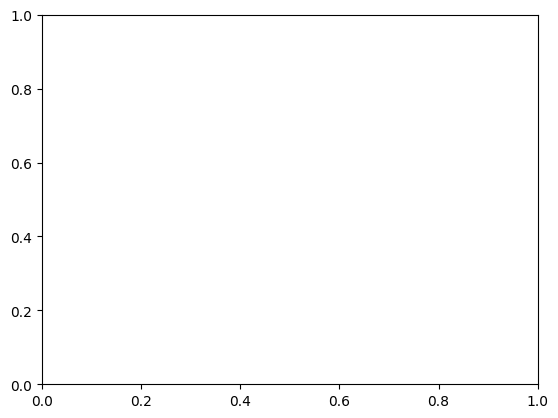

In [50]:
G = nx.Graph()
edge_set = CompositionDAGNode.edge_set

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edge_set, width=6)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()